# Urban Access


This notebook is based on the `urbanaccess` tutorial, with some minor modifications to adapt it to our data and pipelines.

In [1]:
import time

import numpy as np
from scipy import spatial
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib
import matplotlib.pyplot as plt

import pykoda

import pandana as pdna

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network


# Select one or the other for inline or zoomable figures
#%matplotlib inline
#%matplotlib qt

In [2]:
# In this example I will use this data:
company = 'otraf'
date = '2020-08-18'

pykoda.datautils.getstatic.get_static_data(date, company)
path = pykoda.datautils.getstatic._get_static_data_path(company, date)

In [3]:
settings.data_folder = path
settings.to_dict()

TIMERANGE = ['08:00:00', '13:00:00']
SWEREF99 = ccrs.TransverseMercator(central_longitude=15, scale_factor=0.9996, approx=False)

In [4]:
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=path)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.27 seconds
--------------------------------
Processing GTFS feed: otraf_static_2020_08_18
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 6.65 seconds
Unique GTFS feed id operation complete. Took 0.01 seconds
Appended route type to stops
Appended route type to stop_times
--------------------------------
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 2.07 seconds
1 GTFS feed file(s) successfully read as dataframes:
     otraf_static_2020_08_18
     Took 10.58 seconds


Loading the data
----------

We begin building a transit network from the GTFSStatic data.

It will warn about the long time period, but it is actually rather fast.

In [5]:
loaded_feeds.calendar_dates['date_str'] = loaded_feeds.calendar_dates.date.astype(str)

transit_network = ua.gtfs.network.create_transit_net(loaded_feeds, day='tuesday', timerange=TIMERANGE,
                                   #calendar_dates_lookup={'service_id' : '1'},
                                   calendar_dates_lookup={'date_str' : '20200821'},
                                   overwrite_existing_stop_times_int=True,
                                   use_existing_stop_times_int=False)

Using calendar to extract service_ids to select trips.
0 service_ids were extracted from calendar
0 trip(s) 0.00 percent of 10,980 total trip records were found in calendar for GTFS feed(s): []
0 trip(s) 0 percent of 10,980 total trip records were found in calendar for GTFS feed: otraf static 2020 08 18
Using calendar_dates to supplement service_ids extracted from calendar to select trips.
Found 21 records that matched query: column: date_str and string: 20200821 for GTFS feed(s): ['otraf static 2020 08 18']
An additional 21 service_ids were extracted from calendar_dates. Total service_ids extracted: 21
5,128 of 10,980 total trips were extracted representing calendar day: tuesday and calendar_dates search parameters: {'date_str': '20200821'}. Took 0.10 seconds
There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 2.12 seconds
Stop times from 08:00

Visualising it
---------
We can make a quick plot of the data as we have it right now.

Figure created. Took 7.32 seconds


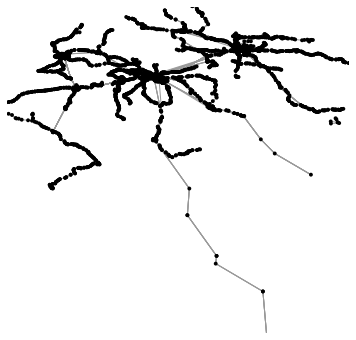

(<Figure size 441.48x432 with 1 Axes>, <AxesSubplot:>)

In [6]:
ua.plot.plot_net(nodes=transit_network.transit_nodes, edges=transit_network.transit_edges)


Headways
-----

This function computes the time it takes to wait and walk between connections.

In [7]:
headways = ua.gtfs.headways.headways(loaded_feeds, headway_timerange=TIMERANGE)
headways.headways

Stop times from 08:00:00 to 13:00:00 successfully selected 27,747 records out of 118,224 total records (23.47 percent of total). Took 0.01 seconds
Starting route stop headway calculation for 5,084 route stops...
Route stop headway calculation complete. Took 29.27 seconds
headway calculation complete. Took 30.59 seconds


count        mean        std     min         25%         50%    75%  \
8397     6.0   47.613889  15.762334   20.85   41.208333   52.416667   60.0   
8412     6.0   47.613889  15.762334   20.85   41.208333   52.416667   60.0   
8427     6.0   47.613889  15.762334   20.85   41.208333   52.416667   60.0   
8442     6.0   47.613889  15.762334   20.85   41.208333   52.416667   60.0   
8457     6.0   47.613889  15.762334   20.85   41.208333   52.416667   60.0   
...      ...         ...        ...     ...         ...         ...    ...   
2189     0.0         NaN        NaN     NaN         NaN         NaN    NaN   
2232     0.0         NaN        NaN     NaN         NaN         NaN    NaN   
10980    1.0  120.000000        NaN  120.00  120.000000  120.000000  120.0   
11021    1.0  120.000000        NaN  120.00  120.000000  120.000000  120.0   
1069     0.0         NaN        NaN     NaN         NaN         NaN    NaN   

         max                    unique_stop_id  \
8397    60.0  9022005000001003_östgötatrafiken   
8412    60.0  9022005000001003_östgötatrafiken   
8427    60.0  9022005000001003_östgötatrafiken   
8442    60.0  9022005000001003_östgötatrafiken   
8457    60.0  9022005000001003_östgötatrafiken   
...      ...                               ...   
2189     NaN  9022005096001001_östgötatrafiken   
2232     NaN  9022005096001002_östgötatrafiken   
10980  120.0  9022005097027002_östgötatrafiken   
11021  120.0  9022005097027002_östgötatrafiken   
1069     NaN  9022005097027002_östgötatrafiken   

                        unique_route_id  \
8397   9011005004000000_östgötatrafiken   
8412   9011005004000000_östgötatrafiken   
8427   9011005004000000_östgötatrafiken   
8442   9011005004000000_östgötatrafiken   
8457   9011005004000000_östgötatrafiken   
...                                 ...   
2189   9011005063100000_östgötatrafiken   
2232   9011005063100000_östgötatrafiken   
10980  9011005063000000_östgötatrafiken   
11021  9011005063000000_östgötatrafiken   
1069   9011005067000000_östgötatrafiken   

                                           node_id_route  
8397   9022005000001003_östgötatrafiken_9011005004000...  
8412   9022005000001003_östgötatrafiken_9011005004000...  
8427   9022005000001003_östgötatrafiken_9011005004000...  
8442   9022005000001003_östgötatrafiken_9011005004000...  
8457   9022005000001003_östgötatrafiken_9011005004000...  
...                                                  ...  
2189   9022005096001001_östgötatrafiken_9011005063100...  
2232   9022005096001002_östgötatrafiken_9011005063100...  
10980  9022005097027002_östgötatrafiken_9011005063000...  
11021  9022005097027002_östgötatrafiken_9011005063000...  
1069   9022005097027002_östgötatrafiken_9011005067000...  

[27747 rows x 11 columns]

Let's add pedestrian information. We need to find the boundaries and query Open Street Maps.

This will take some time, first downloading and then building the network (between 20 and 30 min on my machine):

In [8]:
%%time
lat = transit_network.transit_nodes.y
lon = transit_network.transit_nodes.x
nodes, edges = ua.osm.load.ua_network_from_bbox(lat_min=lat.min(), lat_max=lat.max(),
                                                lng_min=lon.min(), lng_max=lon.max(),
                                                remove_lcn=True) # Remove low connectivity nodes, isolated, probably in the corners of the box

Requesting network data within bounding box from Overpass API in 18 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](56.66139100,14.63446400,57.03941971,15.40625415);>;);out;'}"
Downloaded 19,826.2KB from www.overpass-api.de in 3.23 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](57.03929415,14.63450287,57.41742549,15.41043068);>;);out;'}"
Downloaded 13,793.4KB from www.overpass-api.de in 0.82 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"

Building the network
--------------------------------------------

The output is saved in a global variable.

In [9]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3) # Human walking speed
urbanaccess_net = ua.network.ua_network

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


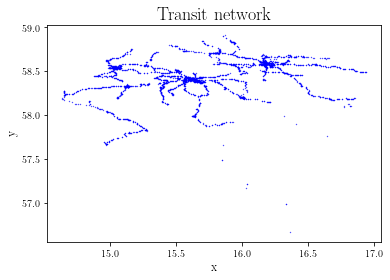

In [10]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)
plt.title('Transit network')
plt.show()

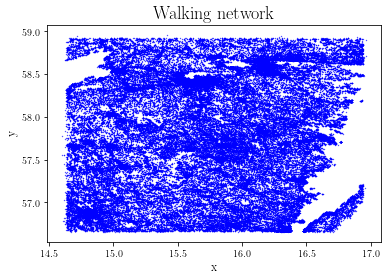

In [11]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)
plt.title('Walking network')
plt.show()

Data integration
---------------

We now proceed to merge both sources of data. It will be inserted in the original net.

In [12]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds)
urbanaccess_net.osm_nodes

Loaded UrbanAccess network components comprised of:
     Transit: 3,409 nodes and 26,331 edges;
     OSM: 219,582 nodes and 590,700 edges
routes successfully joined to transit nodes. Took 0.16 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 6.09 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.06 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 15.06 seconds
Network edge and node network integration completed successfully resulting in a total of 224,665 nodes and 649,860 edges:
     Transit: 5,083 nodes 26,331 edges;
     OSM: 219,582 nodes 590,700 edges; and
     OSM/Transit connector: 32,829 edges.


x          y          id net_type
id                                                   
80678       15.588144  58.411796       80678     walk
80681       15.583691  58.411048       80681     walk
80690       15.578878  58.411482       80690     walk
80701       15.583527  58.412287       80701     walk
80712       15.584333  58.413487       80712     walk
...               ...        ...         ...      ...
8167791482  16.334176  58.672802  8167791482     walk
8167791485  16.333431  58.672583  8167791485     walk
8167791486  16.332038  58.673480  8167791486     walk
8168282409  15.905856  56.752033  8168282409     walk
8168360321  14.819739  56.860454  8168360321     walk

[219582 rows x 4 columns]

## Plotting the network

Figure created. Took 186.81 seconds


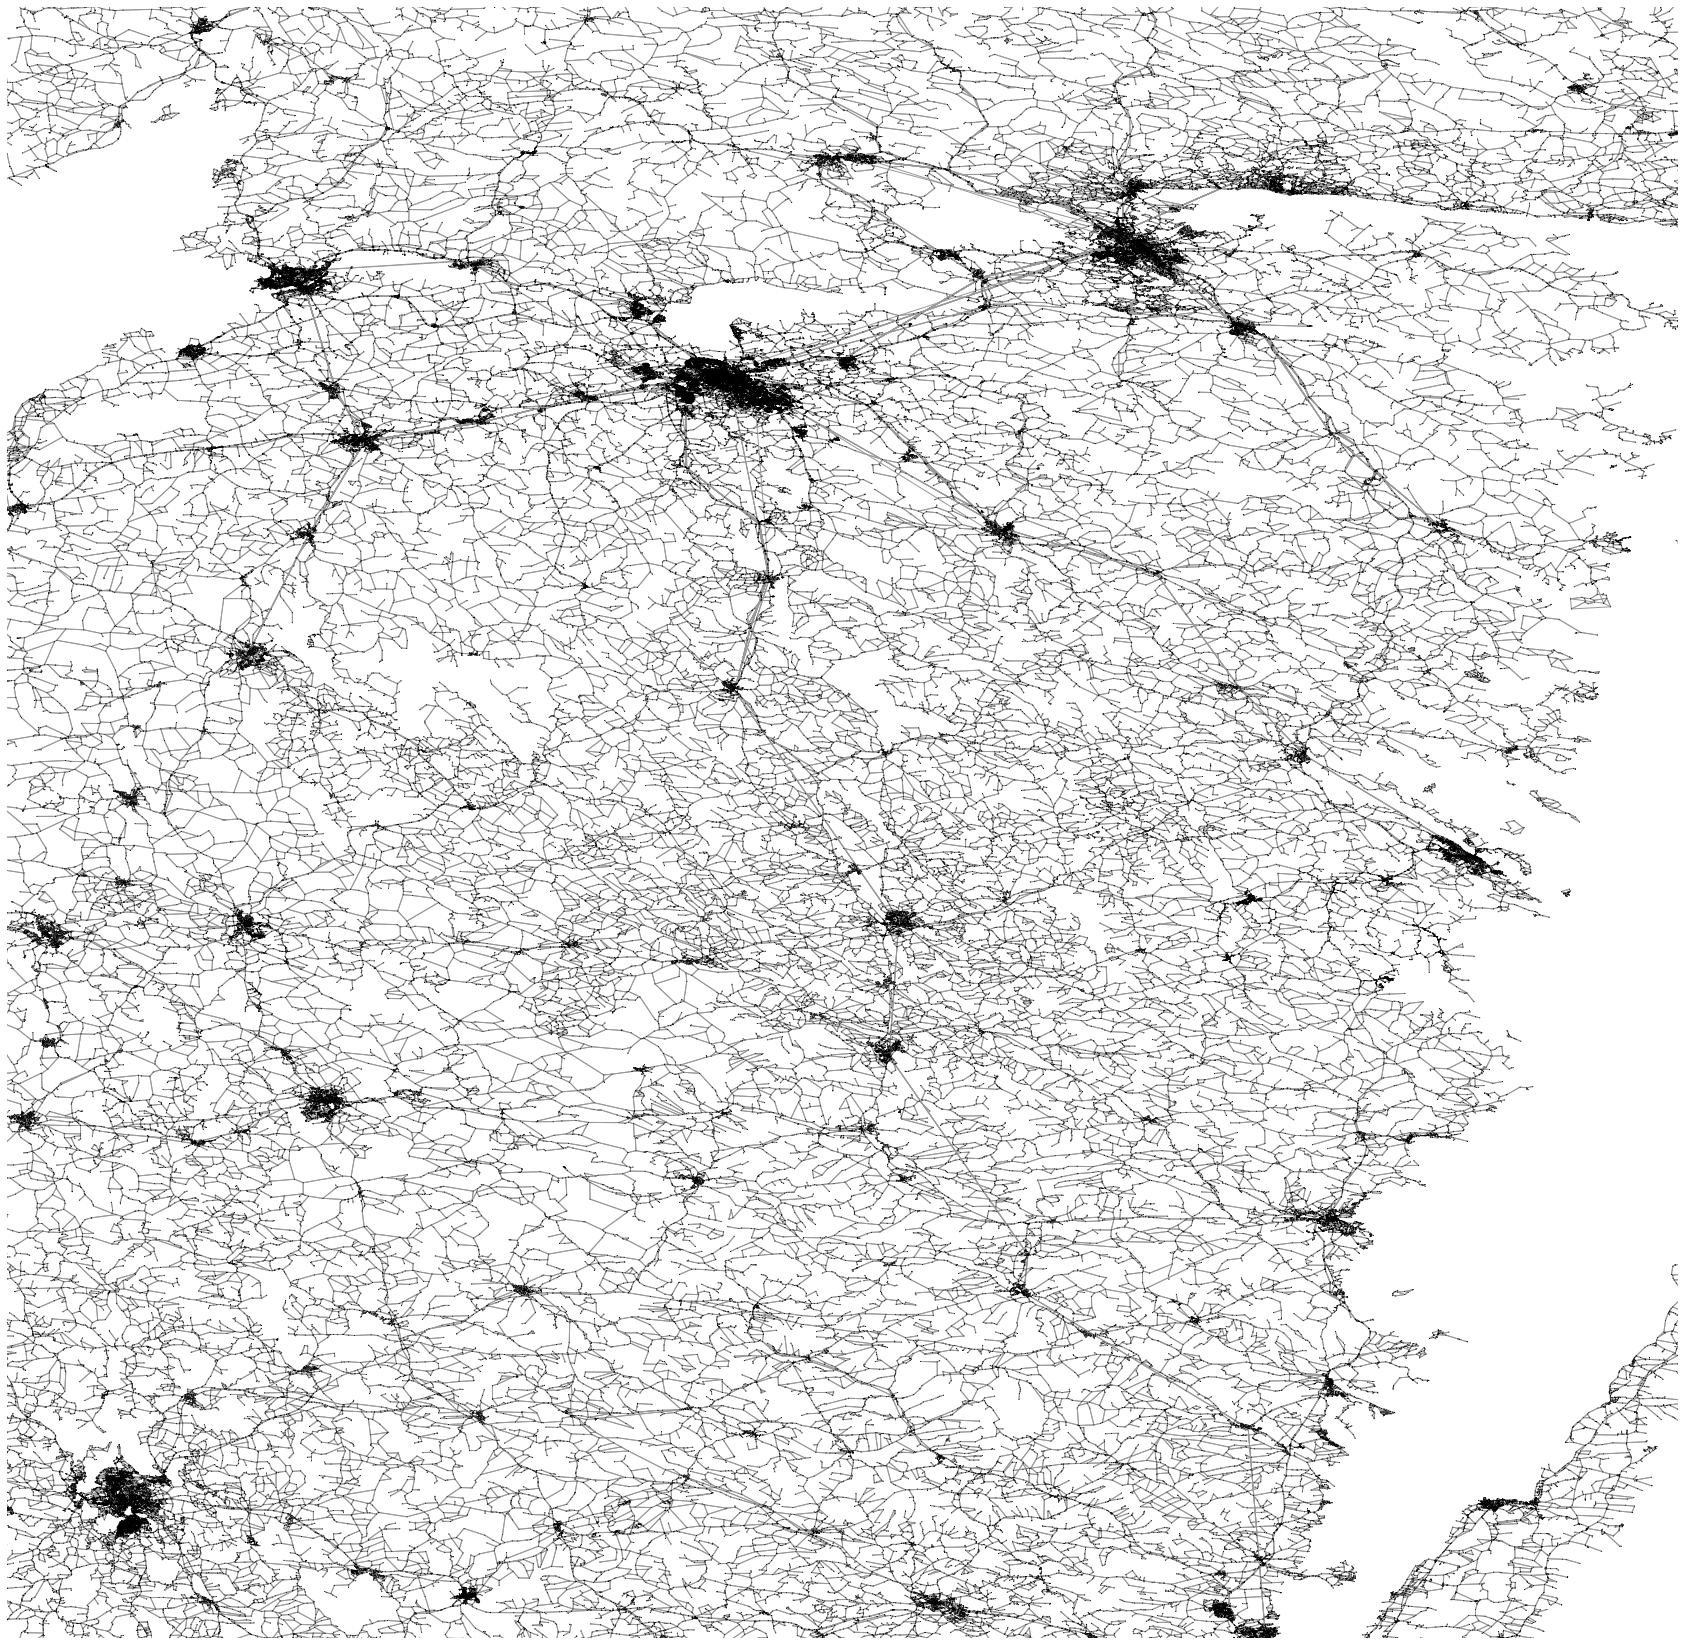

In [13]:
aspect_ratio = (np.ptp(urbanaccess_net.net_nodes.y) / np.ptp(urbanaccess_net.net_nodes.x))
fig = plt.figure(figsize=(30 / aspect_ratio, 30))
ax = plt.axes(projection=SWEREF99)

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False,
                 ax=ax)
plt.show()

### Only the pedestrian component

Figure created. Took 164.34 seconds


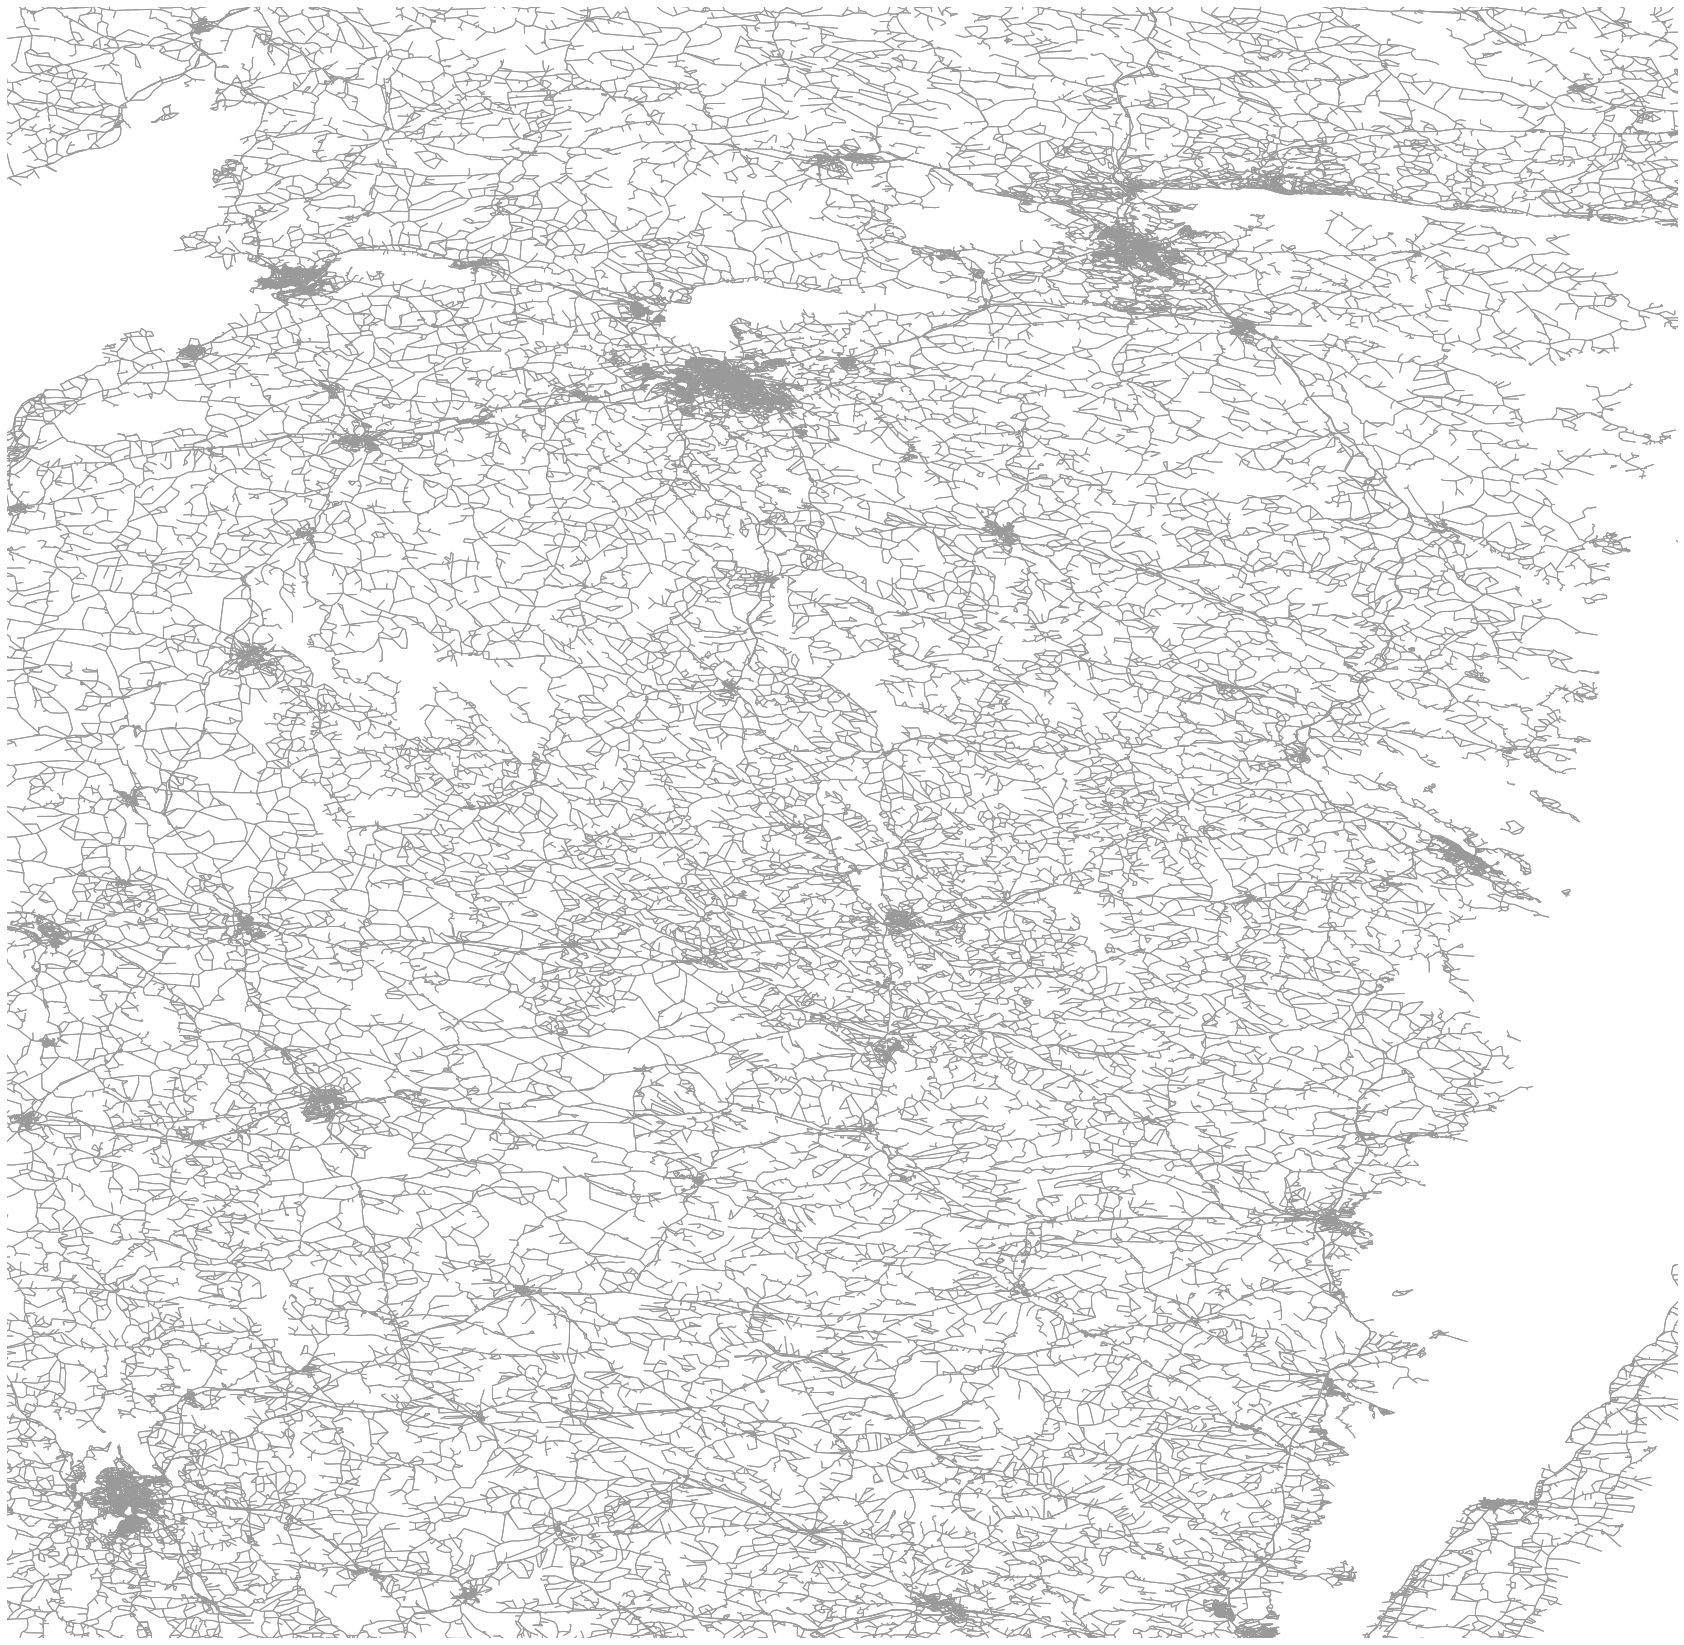

In [14]:
aspect_ratio = (np.ptp(urbanaccess_net.net_nodes.y) / np.ptp(urbanaccess_net.net_nodes.x))
fig = plt.figure(figsize=(30 / aspect_ratio, 30))
ax = plt.axes(projection=SWEREF99)

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type']=='walk'],
                 bbox=None,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False,
                 ax=ax)
plt.show()

### And only the transit one

Figure created. Took 7.52 seconds


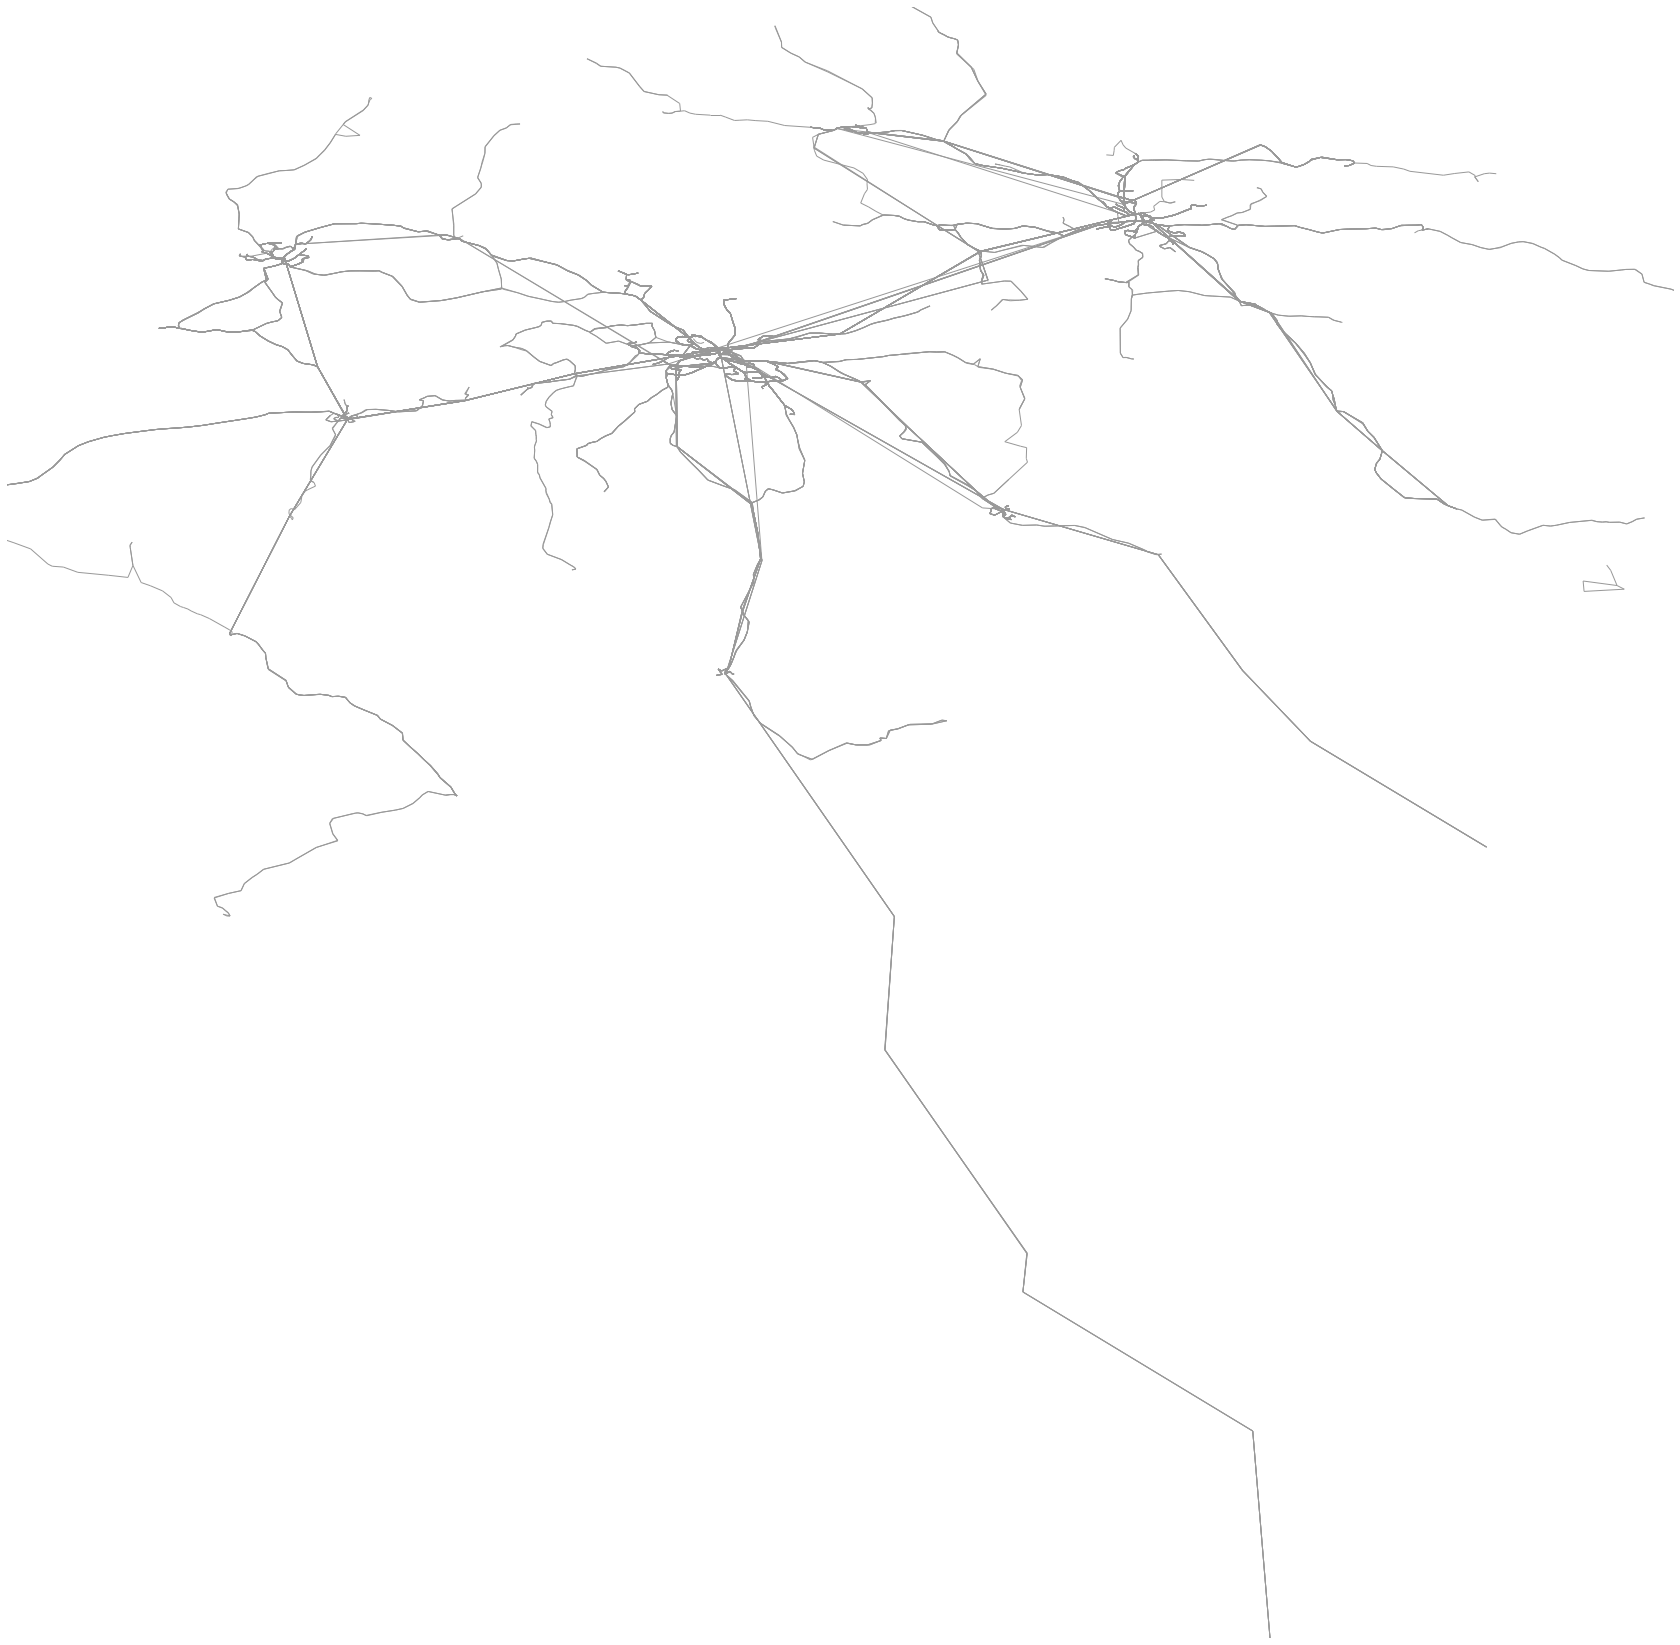

In [15]:
aspect_ratio = (np.ptp(urbanaccess_net.net_nodes.y) / np.ptp(urbanaccess_net.net_nodes.x))
fig = plt.figure(figsize=(30 / aspect_ratio, 30))
ax = plt.axes(projection=SWEREF99)

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type']=='transit'],
                 bbox=None,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False,
                 ax=ax)
plt.show()

# Pandana

Pandana is a network library in Pandas that we can use for heavier computations. We will first load it:

In [16]:
#Loading the network in Pandana
s_time = time.time()
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 44.43 seconds


And we can now define variables.

Let's say the special stations are station heads with the word "centrum", but this could be instead hospitals, supermarkets, or whatever else we would want.

In [17]:
centrum = headways.stops.query('stop_name.str.contains("centrum")', engine='python')

centrum_lat = centrum.stop_lat
centrum_lon = centrum.stop_lon

# Find the closest node with brute-force
d = spatial.distance.cdist(np.stack([transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y], axis=1), np.stack([centrum_lon, centrum_lat], axis=1))
nodes_ids = d.argmin(axis=0)

transit_ped_net.set(nodes_ids, variable=1,  name='centres')

Removed 5 rows because they contain missing values


Here we compute the points that are accessible from them within 15 min 

In [18]:
cent_15 = transit_ped_net.aggregate(15, type='sum', decay='linear', name='centres')

And we now plot them, indicating the centrums with crosses.

Took 0.43 seconds


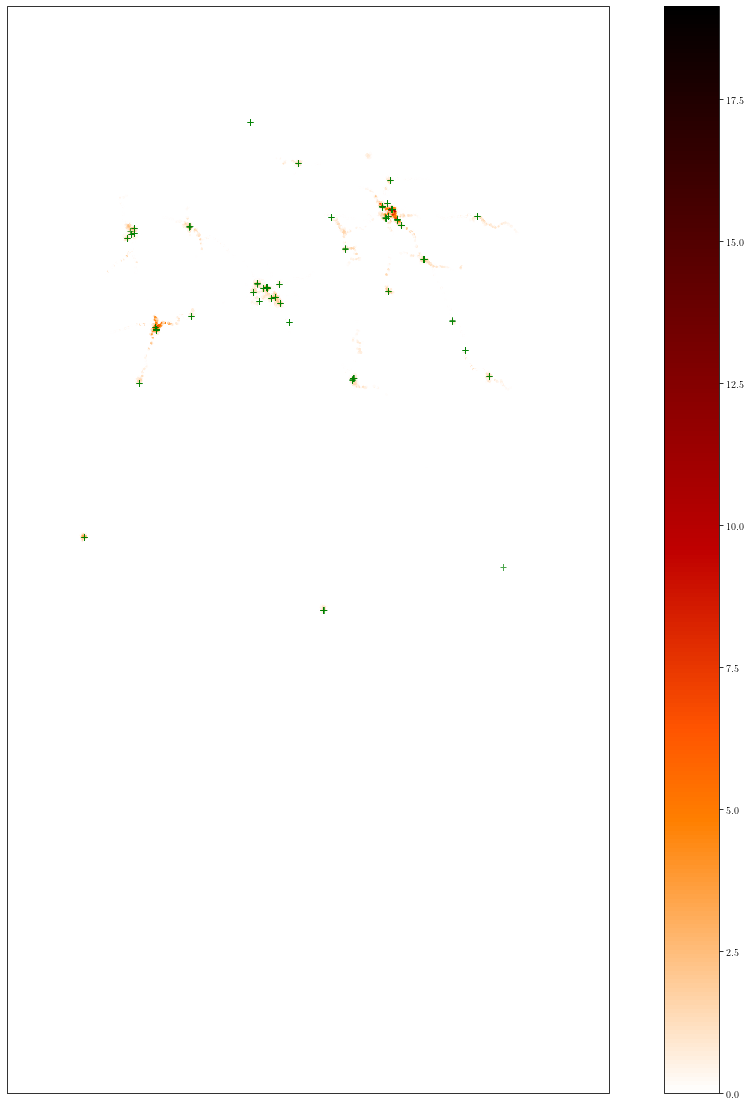

In [19]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=SWEREF99)

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=cent_15, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

centrums = transit_ped_net.nodes_df.iloc[nodes_ids]
plt.scatter(centrums.x, centrums.y, c='g', alpha=0.7, s=30, marker='+', transform=data_crs)

print('Took {:,.2f} seconds'.format(time.time() - s_time))